Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 37, 64)            3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 37, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,251,777
Trainable params: 3,251,777
Non-

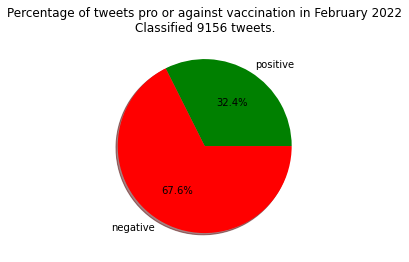

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import itertools

from matplotlib.gridspec import GridSpec
from tensorflow.keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences


dataset_dir = 'sentiment140'
# dataset_dir = 'imdb'
# dataset_dir = 'coronaNLP'

vaccines = ["biontech", "janssen", "moderna",
            "oxford", "sinopharm", "sinovac", "sputnik"]



years = ["2020", "2021", "2022"]
months = ["january", "february", "march", "april", "may", "june",
          "july", "august", "september", "october", "november", "december"]


## MONTHS
models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
model = load_model(models_dir)
model.summary()
tokenizer = joblib.load(tokenizers_dir)
word_index = tokenizer.word_index
for year in years:
    for month in months:
    
        # already processed
        try:
            df = pd.read_csv(f'../{year}-data/covid-{month}.csv', delimiter=',')
        except Exception:
            continue

        df = df.drop_duplicates()

        df = df[['tweet', 'sentiment']]

        df.head()
        

        X = df.iloc[:, 0].fillna(' ')

        tweets = X

        num_of_tweets_analyzed = len(tweets)

        sequences = tokenizer.texts_to_sequences(X)


        # Max number of words in a sequence
        max_length = 37

        padded = pad_sequences(
            sequences, maxlen=max_length, padding="post", truncating="post")

        # Check reversing the indices

        # flip (key, value)
        reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

        def decode(sequence):
            return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

        predictions = model.predict(padded)

        # Only for BinaryCrossentropy
        predictions = [1 if p > 0.5 else 0 for p in predictions]

        # saving tweets to csv
        tweets.to_csv(f'../analysis/tweets-{month}-{year}.csv')
        # saving sentiment predictions to csv
        np.savetxt(f'../analysis/predictions-{month}-{year}.csv',
                   predictions, delimiter=',', fmt=('%s'))

        # adding sentiment column to the beginning
        df = pd.read_csv(
            f'../analysis/predictions-{month}-{year}.csv', header=None)
        df.rename(columns={0: 'sentiment'}, inplace=True)
        # save to new csv file
        df.to_csv(
             f'../analysis/predictions-{month}-{year}.csv', index=False)

        # merging tweets and predictions
        filenames = [f'../analysis/tweets-{month}-{year}.csv',
                       f'../analysis/predictions-{month}-{year}.csv']
        dfs = []
        for filename in filenames:
            # read the csv, making sure the first two columns are str
            df = pd.read_csv(filename, header=None,
                             converters={0: str, 1: str})
            # change the column names so they won't collide during concatenation
            df.columns = [filename + str(cname) for cname in df.columns]
            dfs.append(df)

        # concatenate them horizontally
        merged = pd.concat(dfs, axis=1)
        # write it out
        merged.to_csv(
            f"../analysis/merged-{month}-{year}.csv", header=None, index=None)

        df = pd.read_csv(f'../analysis/merged-{month}-{year}.csv')

        labels = ['negative', 'positive']

        title_type = df.groupby('sentiment').agg('count')

        type_labels = ['positive', 'negative']
        type_counts = title_type.tweet.sort_values()

        colors = ['g', 'r']

        plt.subplot(
            aspect=1, title=f'Percentage of tweets pro or against vaccination in {month.capitalize()} {year}\nClassified {num_of_tweets_analyzed} tweets.')
        type_show_ids = plt.pie(type_counts, labels=type_labels,
                                autopct='%1.1f%%', shadow=True, colors=colors)
        plt.savefig(f"../visuals/{month}-{year}.png")


In [ ]:

# WAR!!
# war = []

# for file in os.listdir("../data/"):
#     war.append(file)
    

# models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
# tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
# model = load_model(models_dir)
# model.summary()
# tokenizer = joblib.load(tokenizers_dir)
# word_index = tokenizer.word_index


# for lang in war:
#     print(lang)
#     # already processed
#     df = pd.read_csv(f'../data/{lang}', delimiter=',')
#     df = df.drop_duplicates()
#     df = df[['tweet', 'translate', 'sentiment']]
#     if not lang == 'war.csv' and not lang == 'war2.csv':
#         df['tweet'] = df['translate']

#     X = df.iloc[:, 0].fillna(' ')

#     tweets = X

#     num_of_tweets_analyzed = len(tweets)

#     sequences = tokenizer.texts_to_sequences(X)

#     # Max number of words in a sequence
#     max_length = 37

#     padded = pad_sequences(
#         sequences, maxlen=max_length, padding="post", truncating="post")

#     # Check reversing the indices

#     # flip (key, value)
#     reverse_word_index = dict([(idx, word)
#                                 for (word, idx) in word_index.items()])


#     predictions = model.predict(padded)
    
#     # Only for BinaryCrossentropy
#     predictions = np.array([1 if p > 0.5 else 0 for p in predictions])
#     print(np.count_nonzero(predictions == 1), np.count_nonzero(predictions == 0))
    
#     # saving tweets to csv
#     tweets.to_csv(f'../analysis/tweets-{lang}.csv')
#     # saving sentiment predictions to csv
#     np.savetxt(f'../analysis/predictions-{lang}.csv',
#             predictions, delimiter=',', fmt=('%s'))
#     # adding sentiment column to the beginning
#     df = pd.read_csv(
#         f'../analysis/predictions-{lang}.csv', header=None)
#     df.rename(columns={0: 'sentiment'}, inplace=True)
#     # save to new csv file
#     df.to_csv(
#         f'../analysis/predictions-{lang}.csv', index=False)
#     # merging tweets and predictions
#     filenames = [f'../analysis/tweets-{lang}.csv',
#                 f'../analysis/predictions-{lang}.csv']
#     dfs = []
#     for filename in filenames:
#         # read the csv, making sure the first two columns are str
#         df = pd.read_csv(filename, header=None,
#                         converters={0: str, 1: str})
#         # change the column names so they won't collide during concatenation
#         df.columns = [filename + str(cname) for cname in df.columns]
#         dfs.append(df)
#     # concatenate them horizontally
#     merged = pd.concat(dfs, axis=1)
#     # write it out
#     merged.to_csv(
#         f"../analysis/merged-{lang}.csv", header=None, index=None)
#     df = pd.read_csv(f'../analysis/merged-{lang}.csv')
#     title_type = df.groupby('sentiment').agg('count')
#     type_labels = ['positive', 'negative']
#     type_counts = title_type.tweet.sort_values()
#     colors = ['g', 'r']
#     plt.subplot(
#         aspect=1, title=f'Classified {num_of_tweets_analyzed} tweets.')
#     type_show_ids = plt.pie(type_counts, labels=type_labels,
#                             autopct='%1.1f%%', shadow=True, colors=colors)
#     plt.savefig(f"../visuals/{lang}.png")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 37, 64)            3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 37, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,251,777
Trainable params: 3,251,777
Non-

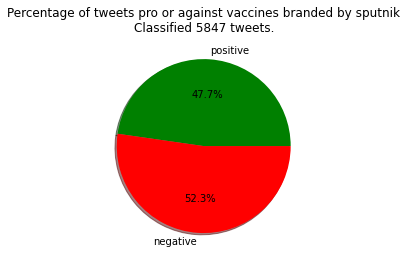

In [4]:
## VACCINES
models_dir = '../models/NN_model_seven_12008898266757515530_0.7899888157844543'
tokenizers_dir = '../tokenizers/12008898266757515530.pkl'
model = load_model(models_dir)
model.summary()
tokenizer = joblib.load(tokenizers_dir)
word_index = tokenizer.word_index
for vaccine in vaccines:
    
    
    # already processed
    df = pd.read_csv(f'../vaccines/{vaccine}.csv', delimiter=',')
    df = df.drop_duplicates()
    df = df[['tweet', 'sentiment']]
    
    
    
    

    X = df.iloc[:, 0].fillna(' ')

    tweets = X

    num_of_tweets_analyzed = len(tweets)

    sequences = tokenizer.texts_to_sequences(X)

    # Max number of words in a sequence
    max_length = 37

    padded = pad_sequences(
          sequences, maxlen=max_length, padding="post", truncating="post")

    # Check reversing the indices

    # flip (key, value)
    reverse_word_index = dict([(idx, word)
                                  for (word, idx) in word_index.items()])

    def decode(sequence):
        return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

    predictions = model.predict(padded)

    # Only for BinaryCrossentropy
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    # saving tweets to csv
    tweets.to_csv(f'../analysis/tweets-{vaccine}.csv')
    # saving sentiment predictions to csv
    np.savetxt(f'../analysis/predictions-{vaccine}.csv',
               predictions, delimiter=',', fmt=('%s'))
    # adding sentiment column to the beginning
    df = pd.read_csv(
        f'../analysis/predictions-{vaccine}.csv', header=None)
    df.rename(columns={0: 'sentiment'}, inplace=True)
    # save to new csv file
    df.to_csv(
         f'../analysis/predictions-{vaccine}.csv', index=False)
    # merging tweets and predictions
    filenames = [f'../analysis/tweets-{vaccine}.csv',
                   f'../analysis/predictions-{vaccine}.csv']
    dfs = []
    for filename in filenames:
        # read the csv, making sure the first two columns are str
        df = pd.read_csv(filename, header=None,
                         converters={0: str, 1: str})
        # change the column names so they won't collide during concatenation
        df.columns = [filename + str(cname) for cname in df.columns]
        dfs.append(df)
    # concatenate them horizontally
    merged = pd.concat(dfs, axis=1)
    # write it out
    merged.to_csv(
        f"../analysis/merged-{vaccine}.csv", header=None, index=None)
    df = pd.read_csv(f'../analysis/merged-{vaccine}.csv')
    labels = ['negative', 'positive']
    title_type = df.groupby('sentiment').agg('count')
    type_labels = ['positive', 'negative']
    type_counts = title_type.tweet.sort_values()
    colors = ['g', 'r']
    plt.subplot(
        aspect=1, title=f'Percentage of tweets pro or against vaccines branded by {vaccine}\nClassified {num_of_tweets_analyzed} tweets.')
    type_show_ids = plt.pie(type_counts, labels=type_labels,
                            autopct='%1.1f%%', shadow=True, colors=colors)
    plt.savefig(f"../visuals/{vaccine}.png")